In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,1,2,4,1926,2,0,88,1,88,88,...,0,1,1,1,0,0,89,43,1787,True
1,1,8,3,1925,2,0,88,1,3,88,...,1,0,1,0,0,0,93,10,3659,False
2,2,2,12,1939,2,0,88,1,88,88,...,1,1,1,0,0,0,75,37,2151,False
3,2,2,4,1954,1,0,88,1,88,88,...,1,1,1,0,0,0,63,32,0,False
4,1,2,3,1963,1,0,88,1,88,88,...,1,1,1,0,0,0,53,10,490,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,2,2,4,1927,2,0,88,1,88,88,...,0,1,1,0,0,0,88,60,644,True
568,1,2,12,1948,2,0,88,1,88,88,...,1,0,1,0,0,0,67,4,0,False
569,1,1,3,1945,1,0,88,1,88,88,...,1,1,1,1,0,9,72,23,1238,False
570,2,2,7,1940,1,0,88,1,88,88,...,0,1,1,0,0,0,76,9,939,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

44.23% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=5
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 927.74


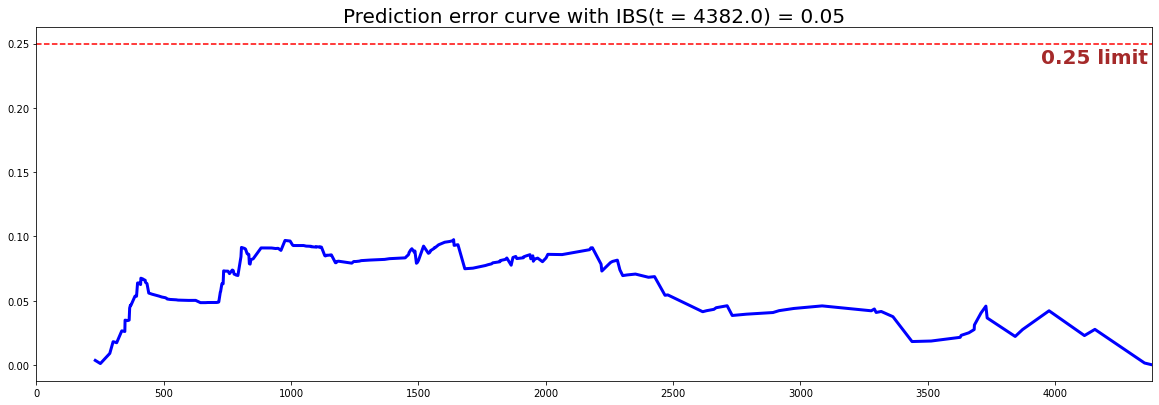

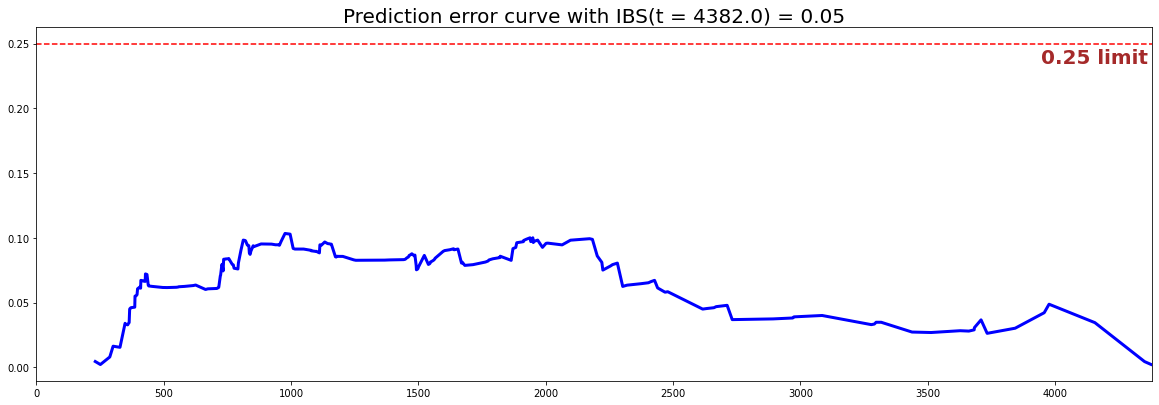

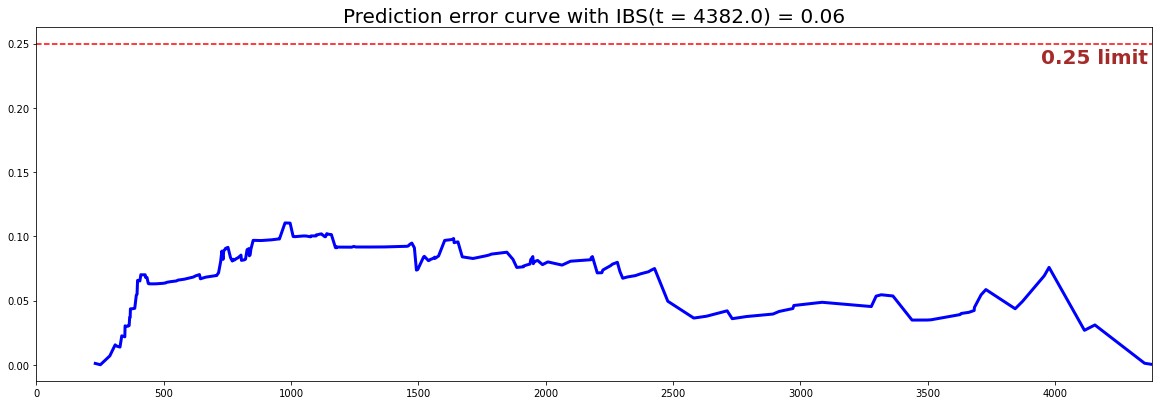

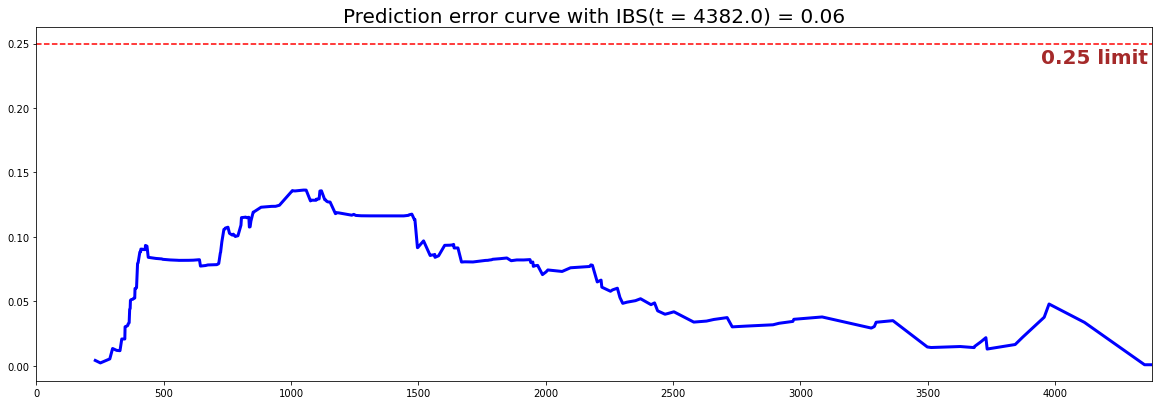

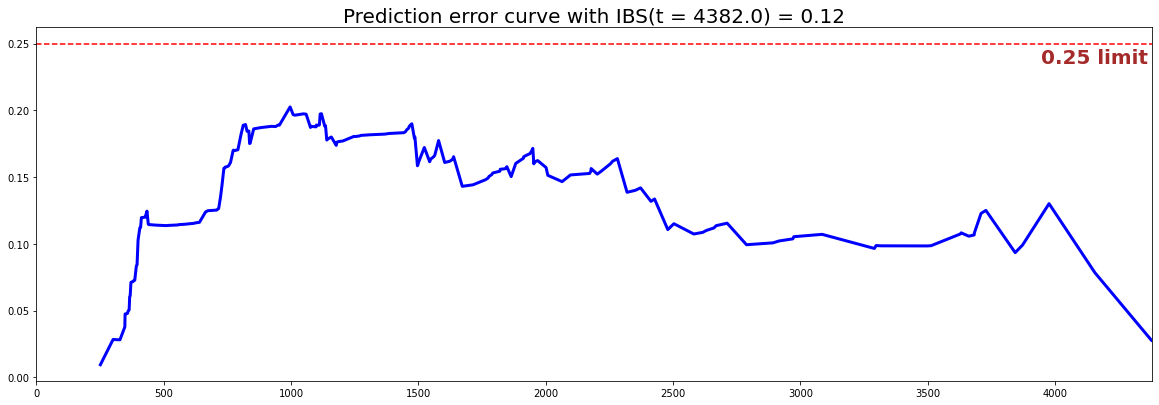

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.8945409497780268, 0.8873821020351047, 0.8841940869366228, 0.8757434640384468, 0.7599502794985132]
0.8603621764573429
0.0505674953691601
[0.05244486554064488, 0.054857512519772104, 0.05811641465751946, 0.056449033190773976, 0.1194839289087025]
0.06827035096348258
0.025674994708180778


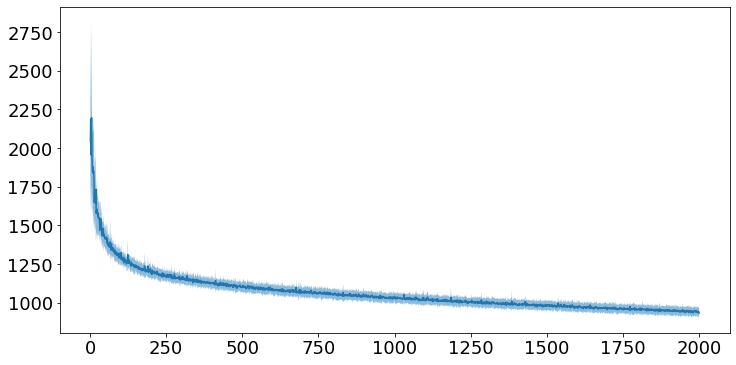

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

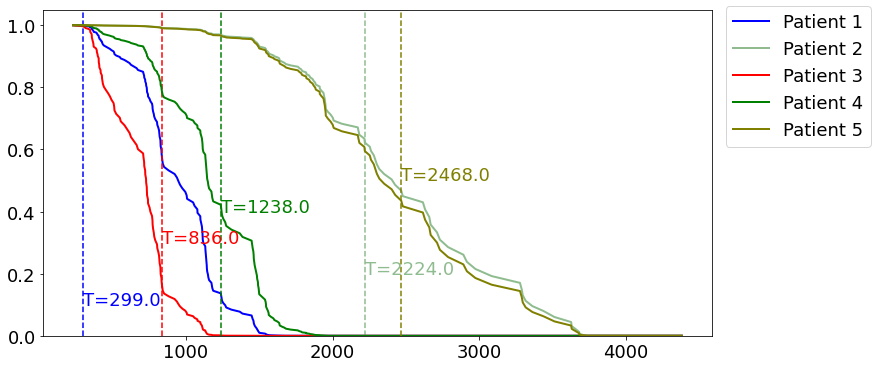

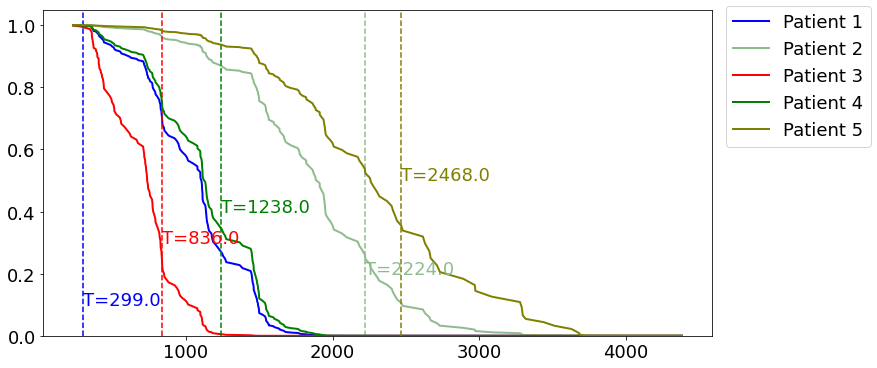

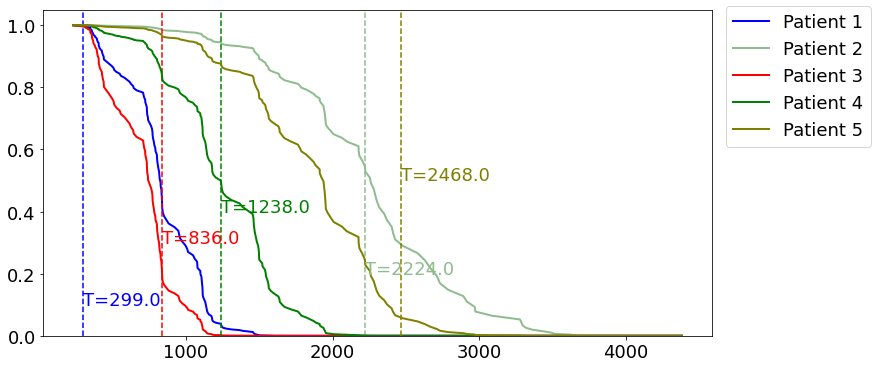

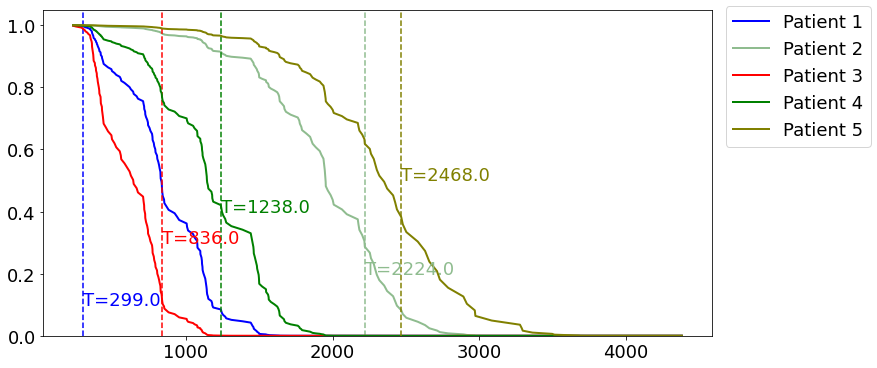

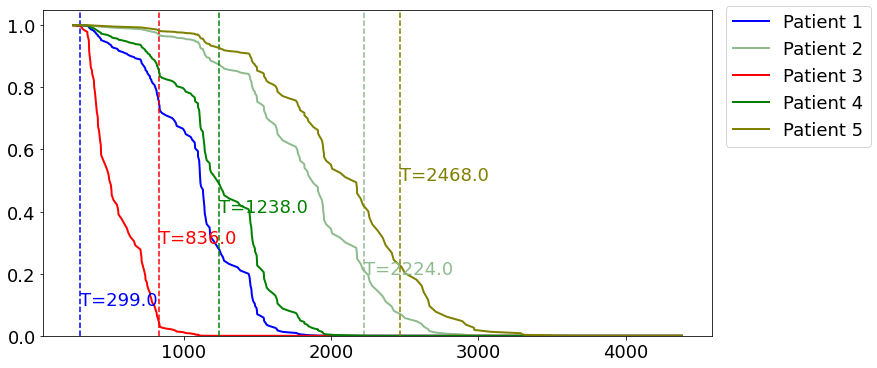

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

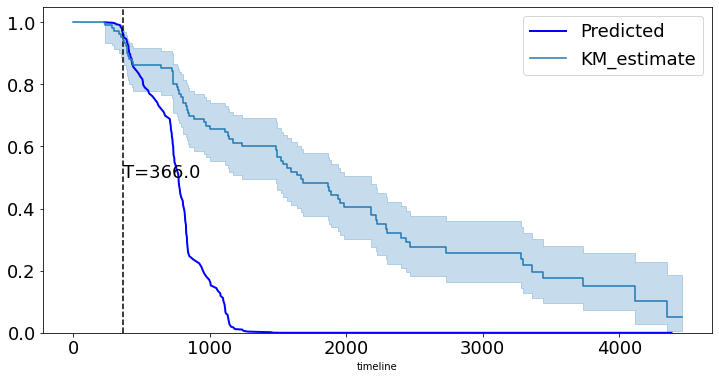

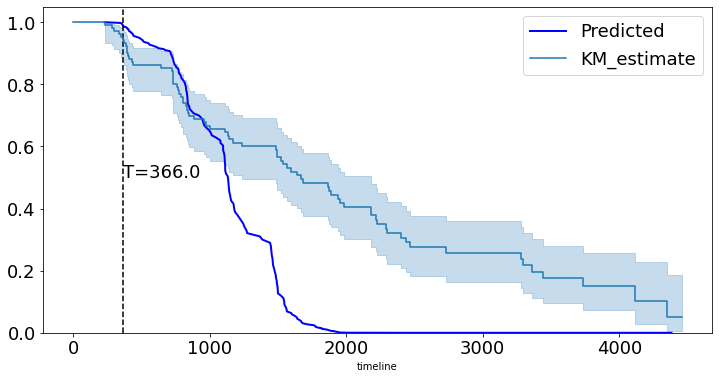

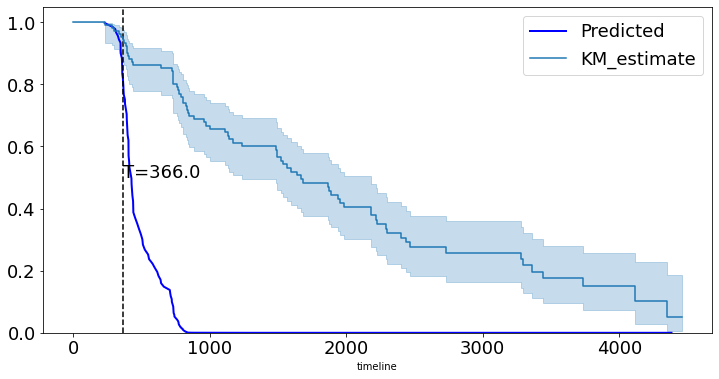

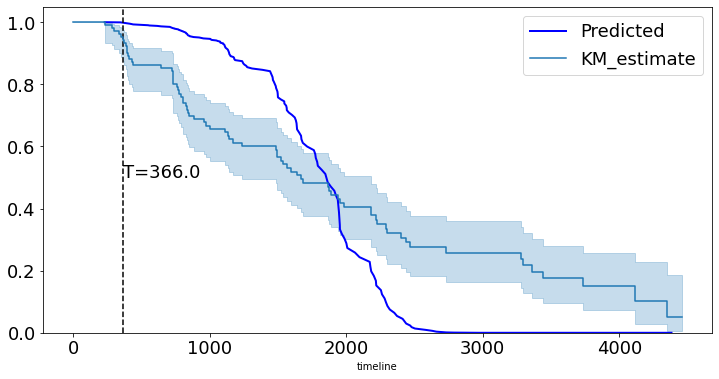

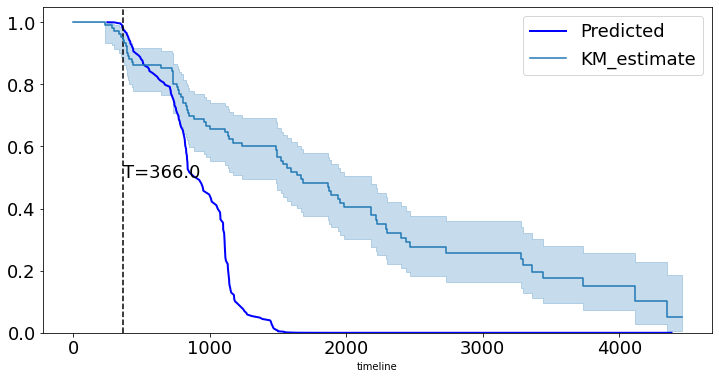

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

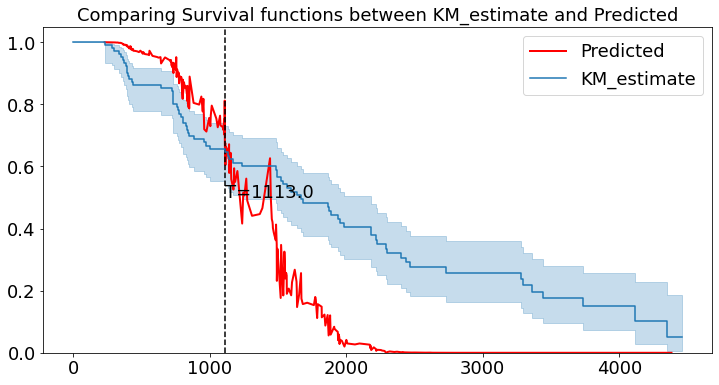

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=243, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFADM',
 'NACCFFTD',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CORTIF',
 'DOWNS',
 'DOWNSIF',
 'HUNT',
 'HUNTIF',
 'PRION',
 'PRIONIF',
 'BRNINJ',
 'BRN

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[105,
 109,
 108,
 35,
 115,
 241,
 20,
 24,
 29,
 22,
 21,
 132,
 222,
 128,
 25,
 12,
 101,
 34,
 37,
 23,
 67,
 197,
 32,
 0,
 232,
 62,
 183,
 129,
 31,
 14,
 165,
 111,
 15,
 151,
 143,
 47,
 233,
 211,
 123,
 176,
 58,
 113,
 11,
 99,
 199,
 118,
 74,
 120,
 3,
 2,
 163,
 131,
 68,
 122,
 119,
 112,
 148,
 127,
 114,
 155,
 174,
 59,
 102,
 166,
 73,
 46,
 124,
 226,
 179,
 181,
 164,
 158,
 10,
 218,
 69,
 26,
 225,
 156,
 178,
 63,
 172,
 238,
 27,
 182,
 188,
 66,
 193,
 16,
 135,
 88,
 83,
 140,
 159,
 72,
 116,
 50,
 96,
 48,
 149,
 42]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([15.61544  , 14.437032 , 12.2154255, 11.952938 , 11.111277 ,
       10.368264 , 10.28379  , 10.229364 , 10.099115 ,  9.955227 ,
        9.9396305,  9.924215 ,  9.922382 ,  9.910545 ,  9.905129 ,
        9.889717 ,  9.851477 ,  9.835949 ,  9.8210745,  9.814239 ,
        9.759922 ,  9.756895 ,  9.740917 ,  9.740377 ,  9.730879 ,
        9.716637 ,  9.711596 ,  9.704256 ,  9.701295 ,  9.695616 ,
        9.660703 ,  9.660474 ,  9.630922 ,  9.627766 ,  9.626844 ,
        9.62305  ,  9.613802 ,  9.610741 ,  9.600191 ,  9.58932  ,
        9.576509 ,  9.573807 ,  9.550079 ,  9.549724 ,  9.548635 ,
        9.542807 ,  9.542227 ,  9.541685 ,  9.537927 ,  9.532713 ,
        9.515667 ,  9.513151 ,  9.51165  ,  9.496031 ,  9.4946995,
        9.486029 ,  9.479333 ,  9.477961 ,  9.470725 ,  9.469738 ,
        9.467482 ,  9.464942 ,  9.46113  ,  9.45924  ,  9.448786 ,
        9.436219 ,  9.428088 ,  9.424415 ,  9.420207 ,  9.418329 ,
        9.4164915,  9.412005 ,  9.40379  ,  9.39875  ,  9.3978

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'NACCAGE', 'NACCIDEM', 'COGMODE', 'NPWBRWT',
       'NACCDAGE', 'ORIENT', 'PERSCARE', 'COGJUDG', 'COMMUN', 'JUDGMENT',
       'NPHISO', 'NPPDXG', 'NPHISMB', 'CDRSUM', 'MARISTAT', 'COGOTHIF',
       'NACCCOGF', 'BEAPATHY', 'HOMEHOBB', 'NACCMCII', 'NPFTDT5',
       'COGATTN', 'NACCREAS', 'NPPDXQ', 'NACCTMCI', 'NPPATH7', 'NPHISG',
       'COGVIS', 'INDEPEND', 'NPOLD3', 'NACCAPOE', 'RESIDENC', 'NPINF3D',
       'NPINF1D', 'NACCBEHF', 'NACCOTHP', 'NPTDPA', 'NACCAVAS', 'NPPATH',
       'DEMENTED', 'NPPMIH', 'EDUC', 'MEDSIF', 'NPFTDT7', 'NPGRCCA',
       'PSP', 'NPGRHA', 'BIRTHYR', 'BIRTHMO', 'NPOLD1', 'NPHIST',
       'IMPNOMCI', 'NPGRLCH', 'NPGRLA', 'NACCNE4S', 'NPINF2F', 'NPTDPAN',
       'NPFIX', 'NPINF4D', 'NACCARTE', 'NACCPPA', 'NACCETPR', 'NPOLD4',
       'PARK', 'BEOTHR', 'NPTAN', 'NPPDXK', 'NPPATH3', 'NPPATH5',
       'NPOLD2', 'NPHEMO', 'PRIMLANG', 'NACCPRIO', 'NACCALZD', 'DECSUB',
       'NPPDXJ', 'NPINF4F', 'NPPATH2', 'NACCMCIL', 'NPOLDD4', 'NACCCSFP',
       'D

In [22]:
np.array(column_names[:-2]).shape

(243,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(243, 150)

In [25]:
first_layer_weight

array([[-0.04021605, -0.04918611, -0.04169797, ...,  0.02414758,
         0.03293172, -0.02389126],
       [ 0.07122485, -0.06644838,  0.0665102 , ...,  0.05404148,
         0.023147  , -0.01761356],
       [-0.07112594, -0.01833979, -0.00325799, ...,  0.02829036,
         0.04404727, -0.0464925 ],
       ...,
       [-0.01396312,  0.02808402,  0.02548885, ..., -0.04000986,
        -0.02522066, -0.00712571],
       [-0.00012727, -0.04029609, -0.03988398, ...,  0.03298246,
        -0.00198862, -0.02087523],
       [ 0.0001716 ,  0.05898296,  0.00439307, ..., -0.03000546,
        -0.02740631, -0.02064773]], dtype=float32)

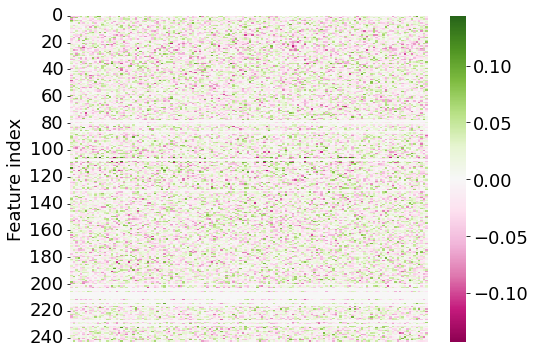

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

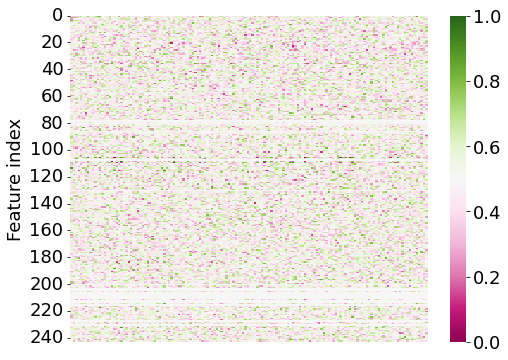

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()